# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

auc 0.9969377311811494


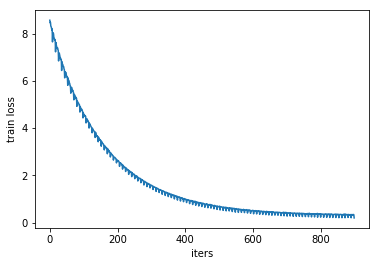

In [8]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
                
                batch_p = self.predict_proba(batch_X)
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                loss = -(batch_y * np.log(batch_p) + (1 - batch_y) * np.log(1 - batch_p)).sum()/self.batch_size
                # add regularization:
                loss += (self.llambda/2 * np.dot(self.w.T, self.w))

                # backward pass
                # <TODO> [2 points] calculate batch gradients
                grad_w = -batch_X.T * (batch_y - batch_p) /self.batch_size
                grad_w += self.llambda * self.w
                grad_b = -(batch_y - batch_p).sum()/self.batch_size

                # SGD optimization step
                # <TODO> [1 point]
                self.w = self.w - self.lr * grad_w
                self.b = self.b - self.lr * grad_b
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        z = X * self.w + self.b
        p = 1/(1+np.exp(-z))
        return p
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [82]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model
        #print(x.size(), self.W.size(), self.b.size())
        Z = torch.mm(x, self.W) + self.b
        # softmax activation:
        #result = torch.exp(Z)/torch.exp(Z).sum()
        return Z

In [78]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [79]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    n_growing = 0
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if epoch_valid_loss > history['valid'][-1]:
            n_growing += 1
        else:
            n_growing = 0
        if n_growing == 5:
            break

    return history 

### predict hard labels [1 point]

In [85]:
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = np.argmax(softmax(model(batch_x)), axis=1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [83]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

c:\users\k1l77\python_envs\torch_env\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



train loss: 3.293 valid loss:3.042



train loss: 2.853 valid loss:2.698



train loss: 2.504 valid loss:2.412



train loss: 2.219 valid loss:2.176



train loss: 1.988 valid loss:1.983



train loss: 1.801 valid loss:1.840



train loss: 1.648 valid loss:1.713



train loss: 1.517 valid loss:1.622



train loss: 1.412 valid loss:1.535



train loss: 1.322 valid loss:1.457



train loss: 1.248 valid loss:1.396



train loss: 1.185 valid loss:1.337



train loss: 1.130 valid loss:1.296



train loss: 1.080 valid loss:1.263



train loss: 1.039 valid loss:1.232



train loss: 1.002 valid loss:1.190



train loss: 0.972 valid loss:1.172



train loss: 0.941 valid loss:1.144



train loss: 0.921 valid loss:1.136



train loss: 0.898 valid loss:1.110



train loss: 0.875 valid loss:1.090



train loss: 0.857 valid loss:1.076



train loss: 0.843 valid loss:1.074



train loss: 0.830 valid loss:1.055



train loss: 0.815 valid loss:1.045



train loss: 0.805 valid loss:1.042



train loss: 0.795 valid loss:1.027



train loss: 0.786 valid loss:1.024



train loss: 0.775 valid loss:1.015



train loss: 0.766 valid loss:1.013



train loss: 0.761 valid loss:1.004



train loss: 0.754 valid loss:0.994



train loss: 0.748 valid loss:0.994



train loss: 0.744 valid loss:0.988



train loss: 0.738 valid loss:0.990



train loss: 0.733 valid loss:0.981



train loss: 0.731 valid loss:0.986



train loss: 0.728 valid loss:0.978



train loss: 0.720 valid loss:0.975



train loss: 0.719 valid loss:0.969



train loss: 0.717 valid loss:0.974



train loss: 0.714 valid loss:0.968



train loss: 0.710 valid loss:0.967



train loss: 0.706 valid loss:0.963



train loss: 0.704 valid loss:0.963



train loss: 0.703 valid loss:0.961



train loss: 0.703 valid loss:0.963



train loss: 0.701 valid loss:0.960



train loss: 0.701 valid loss:0.958



train loss: 0.698 valid loss:0.956



train loss: 0.696 valid loss:0.956



train loss: 0.695 valid loss:0.951



train loss: 0.694 valid loss:0.953



train loss: 0.693 valid loss:0.954



train loss: 0.693 valid loss:0.949



train loss: 0.693 valid loss:0.952



train loss: 0.688 valid loss:0.948



train loss: 0.688 valid loss:0.951



train loss: 0.688 valid loss:0.948



train loss: 0.686 valid loss:0.952



train loss: 0.685 valid loss:0.948



train loss: 0.684 valid loss:0.947



train loss: 0.684 valid loss:0.953



train loss: 0.685 valid loss:0.944



train loss: 0.683 valid loss:0.948



train loss: 0.682 valid loss:0.947



train loss: 0.680 valid loss:0.949



train loss: 0.682 valid loss:0.950



train loss: 0.680 valid loss:0.948



train loss: 0.683 valid loss:0.953



train loss: 0.681 valid loss:0.946



train loss: 0.683 valid loss:0.953



train loss: 0.679 valid loss:0.948



train loss: 0.679 valid loss:0.949



train loss: 0.678 valid loss:0.945



train loss: 0.678 valid loss:0.946



train loss: 0.679 valid loss:0.944



train loss: 0.676 valid loss:0.956



train loss: 0.679 valid loss:0.944



train loss: 0.677 valid loss:0.950



train loss: 0.678 valid loss:0.944



train loss: 0.676 valid loss:0.948



train loss: 0.679 valid loss:0.949



train loss: 0.677 valid loss:0.947



train loss: 0.678 valid loss:0.949



train loss: 0.677 valid loss:0.943



train loss: 0.677 valid loss:0.947



train loss: 0.677 valid loss:0.948



train loss: 0.675 valid loss:0.946



train loss: 0.675 valid loss:0.945



train loss: 0.676 valid loss:0.946



train loss: 0.676 valid loss:0.949



train loss: 0.676 valid loss:0.944



train loss: 0.675 valid loss:0.944



train loss: 0.675 valid loss:0.945



train loss: 0.676 valid loss:0.942



train loss: 0.675 valid loss:0.945



train loss: 0.675 valid loss:0.946



train loss: 0.673 valid loss:0.943



train loss: 0.674 valid loss:0.944


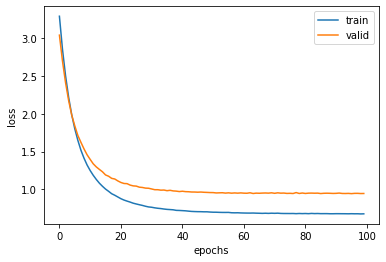

In [84]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [89]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

0.8120021242697822

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

$\hat{p}(y_i=c)$ - predicted probability of object $x_i$ belonging to class $c$

$$CrossEntropyLoss = -\sum_{i=1}^{N} \sum_{c=0}^{19} [y_i = c] log(\hat{p}(y_i=c|x_i)) = -\sum_{i=1}^{N} \sum_{c=0}^{19} |y_i = c| log(0.05) = -log(0.05) \approx 2.995732273553991 $$

In [98]:
-np.log(0.05)

2.995732273553991

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

$$ACC = \frac{\sum_{i=1}^N [y_i = \hat{y_i}]}{N} = \frac{1}{N} \sum_{i=1}^{N}{[y_i = k]} = p(y=k)$$

The accuracy will be equal to the proportion of objects belonging to class K in the dataset, where K is the value of the constant.